Deep learning Python code
- Tensorflow
- CNN model

The used dataset is : https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/data



In [ ]:
# Step 0: Install required packages
!pip install tensorflow keras matplotlib seaborn scikit-learn

# Step 1: Mount Google Drive (if your dataset is in Drive)
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Import libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.image as mpimg

# Step 3: Set dataset paths
train_dir = "/content/drive/My Drive/Colab Notebooks/chest_xray/train"
val_dir = "/content/drive/My Drive/Colab Notebooks/chest_xray/val"
test_dir = "/content/drive/My Drive/Colab Notebooks/chest_xray/test"

# Step 4: Data exploration
# ---- FIXED PART ----
# Safely load class names using a temporary generator
temp_gen = ImageDataGenerator().flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size=1,
    class_mode='binary'
)

classes = list(temp_gen.class_indices.keys())
print("Classes:", classes)




Mounted at /content/drive
Found 5216 images belonging to 2 classes.
Classes: ['NORMAL', 'PNEUMONIA']


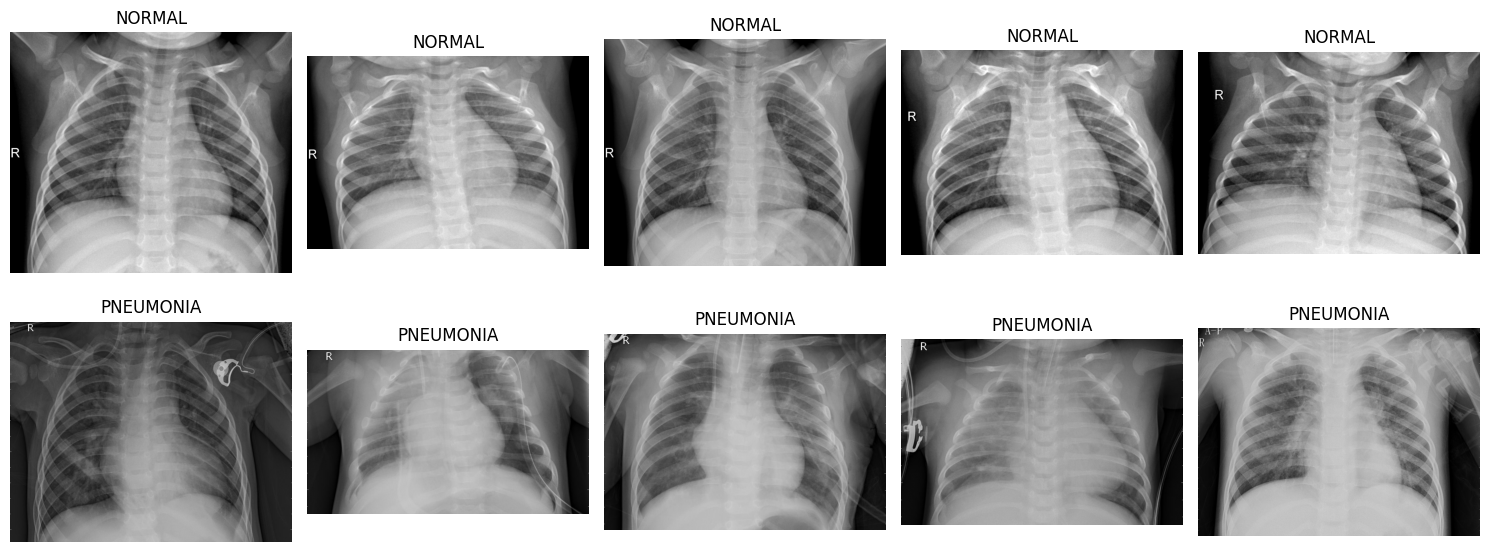

NORMAL: 1342 images
PNEUMONIA: 3876 images
Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

NameError: name 'y_true' is not defined

In [ ]:

# Show sample images for each class
fig, axes = plt.subplots(len(classes), 5, figsize=(15,6))

for i, cls in enumerate(classes):
    cls_dir = os.path.join(train_dir, cls)
    images = os.listdir(cls_dir)[:5]
    for j, img_name in enumerate(images):
        img = mpimg.imread(os.path.join(cls_dir, img_name))
        axes[i, j].imshow(img, cmap='gray')
        axes[i, j].axis('off')
        axes[i, j].set_title(cls)

plt.tight_layout()
plt.show()

# Print class distribution
for cls in classes:
    print(f"{cls}: {len(os.listdir(os.path.join(train_dir, cls)))} images")


# Step 5: Data Preprocessing & Augmentation
IMG_SIZE = (150, 150)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# Step 6: Build CNN Model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()




/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 3379s 21s/step - accuracy: 0.7481 - loss: 0.5722 - val_accuracy: 0.9375 - val_loss: 0.5309
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 87s 533ms/step - accuracy: 0.8725 - loss: 0.3170 - val_accuracy: 0.8125 - val_loss: 0.5589
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 87s 534ms/step - accuracy: 0.8904 - loss: 0.2526 - val_accuracy: 0.9375 - val_loss: 0.4159
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 86s 527ms/step - accuracy: 0.8919 - loss: 0.2411 - val_accuracy: 0.8125 - val_loss: 0.5045
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 87s 533ms/step - accuracy: 0.9101 - loss: 0.2217 - val_accuracy: 0.8750 - val_loss: 0.1934
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 86s 526ms/step - accuracy: 0.9182 - loss: 0.2077 - val_accuracy: 0.8750 - val_loss: 0.3340
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 87s 531ms/step - accuracy: 0.9314 - loss: 0.1747 - val_accuracy: 0.8125 - val_loss: 0.4447
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 86s 527ms/step - accuracy: 0.9304 - loss: 0

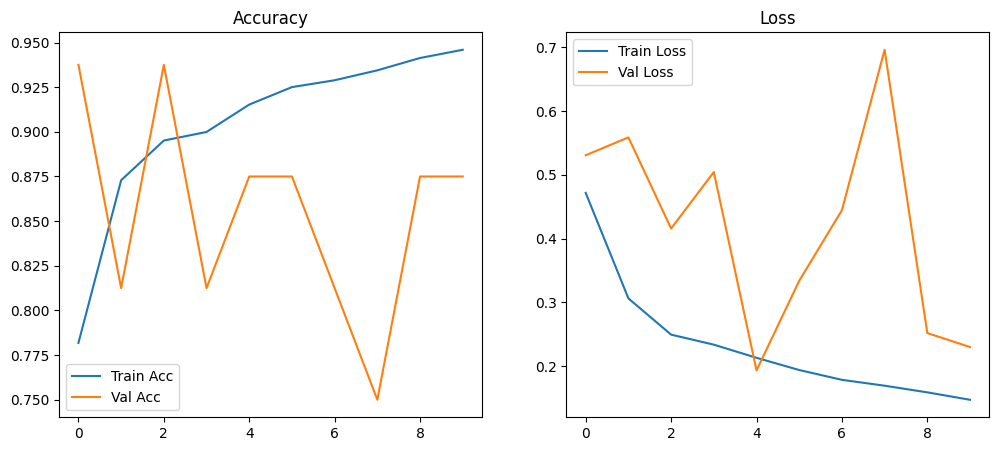

20/20 ━━━━━━━━━━━━━━━━━━━━ 349s 18s/step
              precision    recall  f1-score   support

      NORMAL       0.92      0.74      0.82       234
   PNEUMONIA       0.86      0.96      0.91       390

    accuracy                           0.88       624
   macro avg       0.89      0.85      0.86       624
weighted avg       0.88      0.88      0.87       624



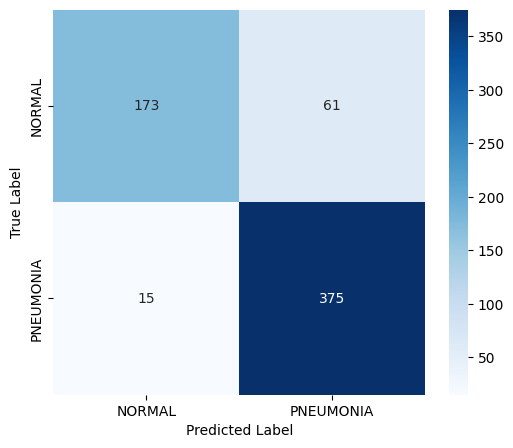

In [ ]:
# Step 7: Train Model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

# Step 8: Evaluate Model
# Training curves
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

# Predict
test_generator.reset()
y_pred = (model.predict(test_generator) > 0.5).astype(int)
y_true = test_generator.classes

print(classification_report(y_true, y_pred, target_names=classes))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()